# RFM Analysis & Clustering for Digital Donors

Please take a look at the readme for more details on the context behind the project! Throughout the notebook, there are comments to explain my thinking/code.

**Important Notes:**
- The code for this notebook will not execute if you try to run it (dependencies missing). It is heavily redacted to ensure privacy of March For Our Lives and our donors, but some code and charts are shown here to demonstrate my process and some outputs of the model. 
- This model was deployed into production and predicted clusters for donors as they joined the ecosystem. Model performance was evalueated and tuned further, which is not shown here. 
- This analysis only takes into account donors who donate less than $5000 as otherwise outliers would skew the value of the model. 

### Checking Completeness of Data

Beyond data sourced from the donor CRM (basic info like name, age, number of contributions, amount of contributions), I compiled additional information on donors from voter files that have their own model scores/consumer data and WealthEngine, which has much more information on the prospective wealth of donors across the country.

These match rates test the amount of matching individuals across CRM, voter, and WealthEngine data as much of that information will be used to characterize the clusters that KMeans picks based on recency, frequency, and monetary value.  

In [5]:
print('VOTER FILE MATCH RATE')
print(indiv_donors['vb_voterbase_id'].notnull().sum()/indiv_donors.shape[0])
print('\nWEALTH ENGINE MATCH RATE')
print(indiv_donors['profile.id'].notnull().sum()/indiv_donors.shape[0])
print('\nMATCHED WE, BUT NOT VF')
print((indiv_donors['profile.id'].notnull() & indiv_donors['vb_voterbase_id'].isnull()).sum()/indiv_donors.shape[0])
print('\nMATCHED VF, BUT NOT WE')
print((indiv_donors['profile.id'].isnull() & indiv_donors['vb_voterbase_id'].notnull()).sum()/indiv_donors.shape[0])
print('\nNO MATCH')
print((indiv_donors['profile.id'].isnull() & indiv_donors['vb_voterbase_id'].isnull()).sum()/indiv_donors.shape[0])

VOTER FILE MATCH RATE
0.815239448051948

WEALTH ENGINE MATCH RATE
0.8102678571428571

MATCHED WE, BUT NOT VF
0.10267857142857142

MATCHED VF, BUT NOT WE
0.10765016233766234

NO MATCH
0.08208198051948051


### Checking if Sample is Representative

Here I'm checking to ensure that the samples we've selected of individuals who match all three sources of data are representative of the full donor database (based on amount and number of contributions). As the p-values show (for 95% confidence), it is not representative, so the model was not generalized to all donors, only those that could match between all three data sources.

In [9]:
from scipy import stats

stat, p_val = stats.ttest_1samp(full_match['total_amount_of_contributions'], indiv_donors['total_amount_of_contributions'].mean())
print(stat, p_val)

stat2, p_val2 = stats.ttest_1samp(full_match['total_number_of_contributions'], indiv_donors['total_number_of_contributions'].mean())
print(stat2, p_val2)

1.5027830880073214 0.1329403311838014
0.8872315206346826 0.3749849046228134


# K Means Model Build

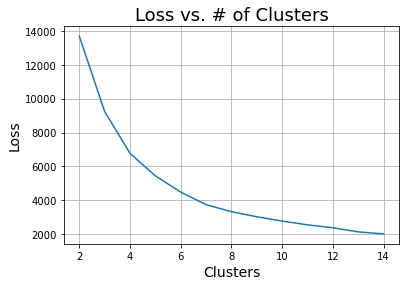

In [13]:
# First step in building the model was to determine the number of clusters. 
# After standardizing the data, using the elbow joint method (see plot below), I determined the optimal 
# number of clusters to be 7. 

from sklearn.cluster import KMeans

test_frame = full_match.copy()

from sklearn.preprocessing import StandardScaler

# Most_recent is Recency, total_number is Frequency, and total_amount is Monetary Value
data_to_standardize = test_frame[['most_recent_contribution_date_diff', 'total_number_of_contributions', 'total_amount_of_contributions']]
scaler = StandardScaler().fit(data_to_standardize)

# Standardize the columns.
standardized_data = test_frame.copy()
standardized_columns = scaler.transform(data_to_standardize)
standardized_data = standardized_columns

# Fit the model.

loss = []
for i in range(2,15):
    kmeans = KMeans(n_clusters=i).fit(standardized_data)
    loss.append(kmeans.inertia_)

plt.plot(range(2,15), loss)
plt.xlabel('Clusters',size=14)
plt.ylabel('Loss',size=14)
plt.title('Loss vs. # of Clusters',size=18)
plt.grid()
plt.show()

In [14]:
# Elbow joint is at 7. Using n_clusters=7, fit the final model and predict cluster membership for each donor.

optimal_k = 7
kmeans = KMeans(n_clusters=7, n_init=15).fit(standardized_data)
test_frame['cluster'] = kmeans.predict(standardized_data)

print(test_frame['cluster'].head(10))

0    6
1    4
2    0
3    0
4    0
5    2
6    6
7    0
8    6
9    0
Name: cluster, dtype: int32


### Characteristics of Clusters

Now that the clusters had been built, to help explain this to stakeholders, I aimed to define certain characteristics of each cluster. The list below, selected_characteristics, contains all the characteristics that I examined (which include several model scores from the voter file). Ultimately, the gift_capacity, gender, gun_control_score, and RFM characteristics themselves were the biggest differentiators between clusters.

In [15]:
from IPython.display import display, HTML

selected_characteristics = ['vanid', 
                     'vb_personal_voice_social_networker_demi_decile',
                     'vb_purely_social_networker_demi_decile',
                    'total_number_of_contributions',
                    'total_amount_of_contributions',
                    'profile.giving.p2g_score.value',
                    'profile.giving.gift_capacity.value',
                    'ts_tsmart_gun_control_score',
                    'predictwise_racial_resentment_score',
                    'predictwise_compassion_score',
                    'profile.wealth.networth.value',
                    'ts_tsmart_children_present_score',
                    'vb_voterbase_gender',
                    'vb_voterbase_marital_status', 
                    'ts_tsmart_college_graduate_score',
                    'vb_voterbase_age']

def cluster_interpretation(list_clusters):
    cluster_summary = pd.DataFrame()
    net_worth = pd.DataFrame()
    gift_capacity = pd.DataFrame()
    for value in list_clusters:
        cluster = test_frame[test_frame['cluster'] == value]
        cluster_summary.loc[value, 'Size of Cluster'] = cluster.shape[0]
        cluster_summary.loc[value, 'Recency'] = cluster['most_recent_contribution_date_diff'].mean()
        cluster_summary.loc[value, 'Frequency'] = cluster['total_number_of_contributions'].mean()
        cluster_summary.loc[value, 'Monetary Value'] = cluster['total_amount_of_contributions'].mean()
        cluster_summary.loc[value, 'Age'] = cluster['vb_voterbase_age'].mean()
        cluster_summary.loc[value, 'Gender'] = cluster['vb_voterbase_gender'].value_counts().index[0]
        cluster_summary.loc[value, 'Children'] = cluster['profile.demographics.has_children'].value_counts().index[0]
        
        cluster_summary.loc[value, 'Gun Control Support'] = cluster['ts_tsmart_gun_control_score'].mean()
        cluster_summary.loc[value, 'Uses Twitter'] = cluster['vb_personal_voice_social_networker_demi_decile'].mean()
        cluster_summary.loc[value, 'Uses FB'] = cluster['vb_purely_social_networker_demi_decile'].mean()
        cluster_summary.loc[value, 'Compassion Score'] = cluster['predictwise_compassion_score'].mean()
        cluster_summary.loc[value, 'Racial Resentment'] = cluster['predictwise_racial_resentment_score'].mean()
        cluster_summary.loc[value, 'Gun Owner'] = cluster['ts_tsmart_gunowner_score'].mean()
        cluster_summary.loc[value, 'Race'] = cluster['vb_voterbase_race'].value_counts().index[0]
        
        net_worth[value] = cluster['profile.wealth.networth.text'].value_counts(normalize=True)
        gift_capacity[value] = cluster['profile.giving.gift_capacity.text'].value_counts(normalize=True)
        
    cluster_summary['Avg Amount Per Contribution'] = cluster_summary['Monetary Value'] / cluster_summary['Frequency']
    cluster_summary['Percent of Sample'] = cluster_summary['Size of Cluster']/test_frame.shape[0]
    cluster_summary.sort_index(inplace=True) 

    display(HTML(cluster_summary.to_html()))
    display(HTML(net_worth.to_html()))
    display(HTML(gift_capacity.to_html()))

<IPython.core.display.Javascript object>


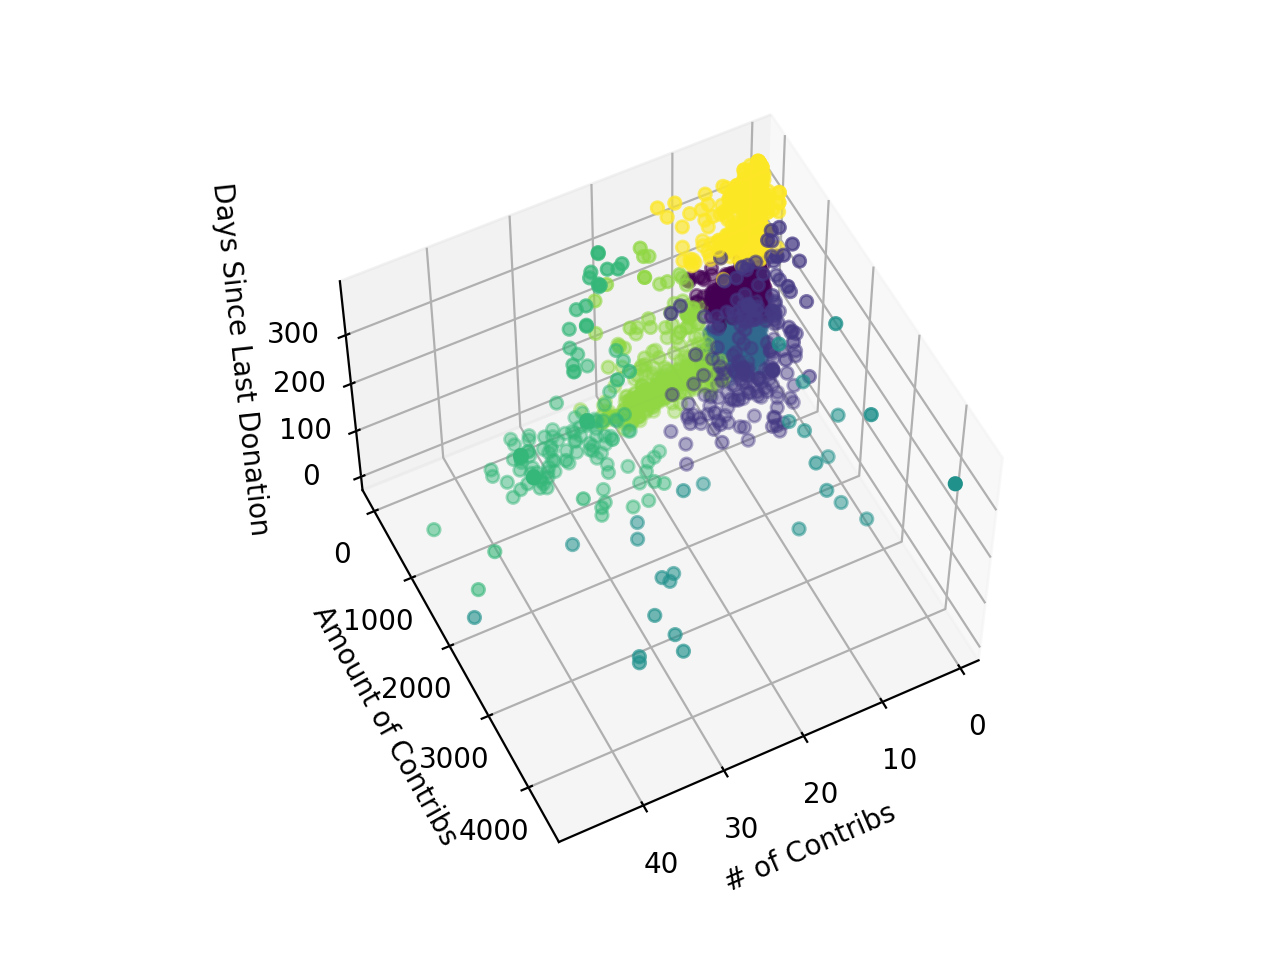

In [18]:
# Graph to visualize the clusters in 3 dimensions. 

from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import axes3d

%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure()
ax = plt.axes(projection='3d')

ax = plt.axes(projection='3d')
ax.scatter3D(test_frame['total_number_of_contributions'], test_frame['total_amount_of_contributions'], 
             test_frame['most_recent_contribution_date_diff'], c = test_frame['cluster'])

ax.set_xlabel('# of Contribs')
ax.set_ylabel('Amount of Contribs')
ax.set_zlabel('Days Since Last Donation')

for angle in range(0, 360):
    ax.view_init(30, angle)
    plt.draw()
    plt.pause(.001)